# Decomposing Multiplicative Time Series in GCP BigQuery (and Python too)
> A tutorial on how to decompose a multiplicative time series in both SQL and Python

- toc: true
- branch: master
- badges: true
- comments: true
- author: Tad Peterson
- categories: [SQL, GCP, BigQuery, Python, time series]

# Introduction
## Motivation
### Why Time Series?
Time series is seemingly inescapable regardless of domain. Even if it is not central to your domain, you will probably have to look at some sort of change over time. So it’s everywhere. It’s an incredibly deep rabbit hole, and this blog post  will only scratch the surface.

### Why SQL (and why GCP)?
SQL is another one of those things that is inescapable for data professionals. A lot of data lives in databases and data warehouses. Before you can read a csv file, it was probably exported from a database. But maybe your data is too big for your computer? At the time of writing this, I am a Sr. Data Engineer, and the data I deal with everyday is too large even for some of the largest VMs on the cloud. It would be more cost effective to just keep the data in your cloud's data warehouse solution or your on prem SQL server.

These examples are using GCP's BigQuery because there are no installation steps to get started, and it is what I use everyday to do my work. Getting started with SQL can be difficult for a lof ot people due to all of the software installation. PostgreSQL is relatively easy to get up and running on a local machine, but getting started with GCP is just signing up for an account. You will need a credit card, but you get (at the time of writing this) `$300` in credits that expire in one year. BigQuery does charge for storage and how much data is processed in a query, but our queries are only going to be in the KB range, so you are safe. FYI BigQuery charges `$5/TB`.

In [1]:
#hide
import pandas as pd
import altair as alt
bq = pd.read_csv('data/bq-timeseries.csv')
bq['reconstructed'] = bq['reconstructed'].astype(pd.Int64Dtype())
bq['Month'] = pd.to_datetime(bq['Month'])

## Time Series Intuition

If you are at all familiar with your data, you are probably aware of some sort of seasonal fluctuation in it. Take retail as an example. It is widely known that the months of November and December make or break a year for retailers. This is an example of seasonality. If we looked at many years of a retailer's sales data, we would see a pattern of higher sales during the holiday months and lower in other months. But looking at all of the unaltered data would be dificult to decide on where the true trend is. Enter time series decomposition!

Initially, you need to understand the window of your seasonality. Is it yearly, quarterly, weekly, etc. If you are unsure of this, then it would be worth attempting to [detect seasonality](https://anomaly.io/detect-seasonality-using-fourier-transform-r/index.html), but this is outside the scope of this post. Once we have decided on the size of the window, which can also depend on how your data is aggregated, we can move on to the next step: choosing between an additive or multiplicative model. The main difference here is how the seasonality behaves. Is the seasonality constant (additive), or does it change as our measured value increases (multiplicative)? We can see this by plotting the data. We will be using the Box and Jenkins airline data for this tutorial. It is sort of a `hello world` for time series decomposition.

In [25]:
#hide_input
alt.Chart(bq).mark_line().encode(
    x='Month:T',
    y='Passengers:Q'
).properties(title='Air Passengers')

alt.Chart(...)

According to the plot above, we can see that the size of the peaks and valleys of our plot, the seasonality, tend to increase as `Passengers` increases. So we will choose a multiplicative model.

The math of decomposing a time series is pretty simple. The most exotic part is a centered moving average, but once you know what each part is, it is pretty basic algebra. See the equation below

`Time Series = Trend * Seasonality * Random Noise`

To follow along, you will need a GCP account, signup [here](https://console.cloud.google.com/) and create an account.

# BigQuery (SQL)
## GCP Setup

### Step 1. Create a project in GCP
- This must be globally unique across all of GCP. My project is called bq-timeseries-proj-51620.

### Step 2. Create a dataset in BigQuery
- From the Navigation menu in the upper left-hand corner, scroll down to BIG DATA and select BigQuery.
- On the left in the Navigation Pane, find your project and click on it.

![bq-proj](images/bq-projects.png)
- In the bottom pane on the right-hand side, click 
![create_dataset](images/create_ds.png)
- Name your dataset, "timeseries". Leave all other defaults and select "Create dataset" at the bottom of the screen.
![name-dataset](images/name-dataset.png)
 - >Note: Note that Data location is important if you want to interact with other datasets and or projects. BigQuery requires that they be in the same location. This is outside the scope of this post, but may be important to note in future projcets.
- You should now see the timeseries dataset below your project in the left-hand pane.

![show-dataset](images/show-dataset.png)

### Step 3. Upload the AirPassengers csv to a BigQuery table.
- First, click on the dataset timeseries that you created in the above step and select 
![create-table](images/create-table.png)
- Select Upload from the "Create table from:" dropdown, and browse to select the AirPassengers.csv (also located [here](https://github.com/tadtenacious/timeseries/blob/master/data/AirPassengers.csv)). Make sure your project and dataset are correct. Name the table raw_airpassengers. Check Auto detect under Schema. Leave all other defualts and click Create table 
![upload-table](images/upload-table.png)
- Now we are ready to start coding.


### Step 4. Clean the Data
- Back in the left-hand pane, you should be able to click on your dataset and see the raw_airpassengers table below it. Click on the table and you will be able to see the table's Schema. 
![raw-schema](images/raw-schema.png)
- If you click Preview, you can see the data and why the `Month` column has the `String` datatype. 
![raw-data](images/raw-data.png)

- Trying to simply cast the Month column as a date will result in an error 
![invalide-date](images/invalid-date.png)

- Because we are only concerned with the monthly data, we can concatenate `'-01'` to the end of the `Month` column and convert or cast this as a date. And because we don't want to have to do this step everytime we want to query the data, we will save our results to a table. I've also renamed the `Month` column to `mnth`. It is generally a best practice to avoid reserved words as column names. 

```sql
CREATE OR REPLACE TABLE
  `timeseries.airpassengers` AS
SELECT
  CAST(Month || '-01' AS DATE) AS mnth,
  Passengers
FROM
  `timeseries.raw_airpassengers`
```

### Step 5. Extract the Trend
- The trend in this context is a centered moving average. We can use the `OVER()` clause with the `AVG()` function in BigQuery to accomplish this. We believe the periodicity to be yearly/12 months. So we must center the average around this window. We will opt to use 6 months before and 5 months after the actual month. This includes the actual month making the period a full year. You can read more about the `OVER()` clause in [BigQuery here](https://cloud.google.com/bigquery/docs/reference/standard-sql/analytic-function-concepts).

```sql
SELECT
    mnth,
    passengers,
    AVG(CAST(Passengers AS NUMERIC)) 
      OVER(
        ORDER BY mnth 
        ROWS BETWEEN 6 PRECEDING AND 5 FOLLOWING
      ) AS trend
FROM
  `timeseries.airpassengers`
```

In [3]:
#hide_input
temp = pd.read_csv('data/bq-initial-trend.csv')
temp

,mnth,passengers,trend
0,1949-01-01,112,124.500000
1,1949-02-01,118,127.857143
2,1949-03-01,132,130.375000
3,1949-04-01,129,131.000000
4,1949-05-01,121,129.800000
5,1949-06-01,135,127.454545
6,1949-07-01,148,126.666667
7,1949-08-01,148,126.916667
8,1949-09-01,136,127.583333
9,1949-10-01,119,128.333333


But you will notice that all months are returned in the result set even if they do not have data 6 months before or after the actual month. These values are not truly centered and must be ommitted. I'll choose to solve this using [common table expressions](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax#with_clause) to make multiple passes at the data.

```sql
WITH initial AS (
  SELECT
    mnth,
    passengers,
    AVG(CAST(Passengers AS NUMERIC)) 
      OVER(
        ORDER BY mnth 
        ROWS BETWEEN 6 PRECEDING AND 5 FOLLOWING
      ) AS trend
  FROM
    `timeseries.airpassengers`)
SELECT
  a.mnth
  ,a.passengers
  ,a.trend
FROM initial a
WHERE EXISTS (
            SELECT 1 FROM initial x
            WHERE a.mnth = DATE_SUB(x.mnth, INTERVAL 5 MONTH)
            )
AND EXISTS (
          SELECT 1 FROM initial x
            WHERE a.mnth = DATE_ADD(x.mnth, INTERVAL 6 MONTH)
            )
```

In [4]:
#hide_input
bq[~bq['trend'].isnull()][['Month','Passengers','trend']].rename({'Month': 'mnth', 'Passengers':'passengers'},axis=1).head()

,mnth,passengers,trend
6,1949-07-01,148,126.666667
7,1949-08-01,148,126.916667
8,1949-09-01,136,127.583333
9,1949-10-01,119,128.333333
10,1949-11-01,104,128.833333


In [5]:
#hide_input
alt.Chart(bq).transform_fold(
    ['Passengers','trend']
).mark_line().encode(
    x='Month:T',
    y='value:Q',
    color='key:N'
).properties(title='Trend')

alt.Chart(...)

### Step 6. Detrend the Data
- Removing the trend from the data will leave use with the seasonality. We believe our time series to be multiplicative, so we will divide the passengers column by the trend.

```sql
WITH initial AS (
  SELECT
    mnth,
    passengers,
    AVG(CAST(Passengers AS NUMERIC)) 
      OVER(
        ORDER BY mnth 
        ROWS BETWEEN 6 PRECEDING AND 5 FOLLOWING
      ) AS trend
FROM
  `timeseries.airpassengers`),
trend AS (
  SELECT
    a.mnth
    ,a.passengers
    ,a.trend
  FROM initial a
  WHERE EXISTS (
                SELECT 1 FROM initial x
                WHERE a.mnth = DATE_SUB(x.mnth, INTERVAL 5 MONTH)
                )
  AND EXISTS (
              SELECT 1 FROM initial x
                WHERE a.mnth = DATE_ADD(x.mnth, INTERVAL 6 MONTH)
                )
)             
SELECT
  t.mnth
  ,t.passengers
  ,t.trend
  ,CAST(t.passengers AS NUMERIC) / t.trend AS detrend
FROM trend t
```

In [6]:
#hide_input
bq[~bq['trend'].isnull()][['Month','Passengers','trend','detrend']].rename({'Month': 'mnth', 'Passengers':'passengers'},axis=1).head()

,mnth,passengers,trend,detrend
6,1949-07-01,148,126.666667,1.168421
7,1949-08-01,148,126.916667,1.166120
8,1949-09-01,136,127.583333,1.065970
9,1949-10-01,119,128.333333,0.927273
10,1949-11-01,104,128.833333,0.807245


In [16]:
#hide_input
alt.Chart(bq).mark_line().encode(
    x='Month:T',
    y='detrend:Q'
).properties(title='Detrend')

alt.Chart(...)

### Step 7. Extract the Random Noise
-  To extract the random noise, we need to remove the seasonality. Seasonality is the average of the detrended data grouped by month in our case. And because our SQL query is getting pretty long, I'll but cutting it up in the examples, but a complete sql script can be found [here](https://github.com/tadtenacious/timeseries/blob/master/sql/timeseries.sql).

```sql
), detrend AS (              
  SELECT
    t.mnth
    ,t.passengers
    ,t.trend
    ,CAST(t.passengers AS NUMERIC) / t.trend AS detrend
  FROM trend t
)
SELECT
  d.mnth
  ,d.passengers
  ,d.trend
  ,d.detrend
  ,AVG(d.detrend) OVER (PARTITION BY EXTRACT(MONTH FROM d.mnth)) AS avg_seasonality
FROM detrend d
```

In [8]:
#hide_input
bq[~bq['trend'].isnull()][['Month','Passengers','trend','avg_seasonality']].rename({'Month': 'mnth', 'Passengers':'passengers'},axis=1).head(12)

,mnth,passengers,trend,avg_seasonality
6,1949-07-01,148,126.666667,1.230005
7,1949-08-01,148,126.916667,1.222717
8,1949-09-01,136,127.583333,1.063440
9,1949-10-01,119,128.333333,0.924510
10,1949-11-01,104,128.833333,0.803798
11,1949-12-01,118,129.166667,0.902477
12,1950-01-01,115,130.333333,0.914743
13,1950-02-01,126,132.166667,0.887863
14,1950-03-01,141,134.000000,1.010943
15,1950-04-01,135,135.833333,0.978781


- Given our equation for multiplicative time series is `time series = trend * seasonality * random noise`, we simply isoloate the variable `random noise` to get `random noise = time series / (seasonality * trend)`

```sql
), seasonality AS (
SELECT
  d.mnth
  ,d.passengers
  ,d.trend
  ,d.detrend
  ,AVG(d.detrend) OVER (PARTITION BY EXTRACT(MONTH FROM d.mnth)) AS avg_seasonality
FROM detrend d
)
SELECT
  s.mnth
  ,s.Passengers
  ,s.trend
  ,s.detrend
  ,s.avg_seasonality
  ,s.Passengers / (s.avg_seasonality * s.trend) AS random_noise
FROM seasonality s
```

In [9]:
#hide_input
bq[~bq['trend'].isnull()][['Month','Passengers','trend','avg_seasonality','random_noise']].rename({'Month': 'mnth', 'Passengers':'passengers'},axis=1).head(10)

,mnth,passengers,trend,avg_seasonality,random_noise
6,1949-07-01,148,126.666667,1.230005,0.949932
7,1949-08-01,148,126.916667,1.222717,0.953712
8,1949-09-01,136,127.583333,1.063440,1.002379
9,1949-10-01,119,128.333333,0.924510,1.002988
10,1949-11-01,104,128.833333,0.803798,1.004287
11,1949-12-01,118,129.166667,0.902477,1.012268
12,1950-01-01,115,130.333333,0.914743,0.964592
13,1950-02-01,126,132.166667,0.887863,1.073748
14,1950-03-01,141,134.000000,1.010943,1.040849
15,1950-04-01,135,135.833333,0.978781,1.015411


In [17]:
#hide_input
alt.Chart(bq).mark_line().encode(
    x='Month:T',
    y='random_noise:Q'
).properties(title='Random Noise')

alt.Chart(...)

### Step 8. Reconstruct the Time Series
Now that we have all of the parts of our time series, we can actually reconstruct the original time series using each of its parts given our equation: `time series = trend * seasonality * random noise`. While we are at it, we will go back and get the portion of our data that we omitted.

```sql
), time_series AS (
  SELECT
    s.mnth
    ,s.Passengers
    ,s.trend
    ,s.detrend
    ,s.avg_seasonality
    ,s.Passengers / (s.avg_seasonality * s.trend) AS random_noise
  FROM seasonality s
)
SELECT
  a.mnth AS Month
  ,a.Passengers 
  ,t.trend
  ,t.detrend
  ,t.avg_seasonality
  ,t.random_noise
  ,CAST(ROUND(t.trend * t.avg_seasonality * t.random_noise,0) AS INT64) AS reconstructed
FROM `timeseries.airpassengers` a
LEFT JOIN time_series t ON a.mnth= t.mnth
ORDER BY 1
```

In [11]:
#hide_input
bq.head(12)

,Month,Passengers,trend,detrend,avg_seasonality,random_noise,reconstructed
0,1949-01-01,112,NaN,NaN,NaN,NaN,<NA>
1,1949-02-01,118,NaN,NaN,NaN,NaN,<NA>
2,1949-03-01,132,NaN,NaN,NaN,NaN,<NA>
3,1949-04-01,129,NaN,NaN,NaN,NaN,<NA>
4,1949-05-01,121,NaN,NaN,NaN,NaN,<NA>
5,1949-06-01,135,NaN,NaN,NaN,NaN,<NA>
6,1949-07-01,148,126.666667,1.168421,1.230005,0.949932,148
7,1949-08-01,148,126.916667,1.166120,1.222717,0.953712,148
8,1949-09-01,136,127.583333,1.065970,1.063440,1.002379,136
9,1949-10-01,119,128.333333,0.927273,0.924510,1.002988,119


In [12]:
#hide_input
original = alt.Chart(bq).mark_line().encode(
    x='Month:T',
    y='Passengers:Q'
).properties(title='Original')
reconstructed = alt.Chart(bq).mark_line(color='red').encode(
    x='Month:T',
    y='reconstructed:Q'
).properties(title='Reconstructed')
original | reconstructed

alt.HConcatChart(...)

As you can see, we were able to recreate the original time series values.

# Python
As promised, I will show the same steps in Python.

### Read and Clean the Data

In [14]:
air = pd.read_csv('data/AirPassengers.csv', parse_dates=['Month'])
air.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


### Extract the Trend

In [18]:
air['trend'] = air.rolling(window=12,center=True).mean()
air.head(10)

,Month,Passengers,trend
0,1949-01-01,112,NaN
1,1949-02-01,118,NaN
2,1949-03-01,132,NaN
3,1949-04-01,129,NaN
4,1949-05-01,121,NaN
5,1949-06-01,135,NaN
6,1949-07-01,148,126.666667
7,1949-08-01,148,126.916667
8,1949-09-01,136,127.583333
9,1949-10-01,119,128.333333


### Detrend the Data

In [20]:
air['detrend'] = air['Passengers'] / air['trend']
air.iloc[6:11]

,Month,Passengers,trend,detrend
6,1949-07-01,148,126.666667,1.168421
7,1949-08-01,148,126.916667,1.166120
8,1949-09-01,136,127.583333,1.065970
9,1949-10-01,119,128.333333,0.927273
10,1949-11-01,104,128.833333,0.807245


### Extract the Random Noise

In [21]:
# for grouping by month
air['Month_int'] = air['Month'].dt.month
avg_seasonality = air[['Month_int','detrend']].groupby('Month_int',as_index=False).mean()\
.rename({'detrend': 'avg_seasonality'}, axis=1)
avg_seasonality

,Month_int,avg_seasonality
0,1,0.914743
1,2,0.887863
2,3,1.010943
3,4,0.978781
4,5,0.983574
5,6,1.115711
6,7,1.236360
7,8,1.222717
8,9,1.063440
9,10,0.924510


In [22]:
new_air = air.merge(avg_seasonality, on='Month_int', how='left').sort_values(by='Month')
new_air.head(10)

,Month,Passengers,trend,detrend,Month_int,avg_seasonality
0,1949-01-01,112,NaN,NaN,1,0.914743
1,1949-02-01,118,NaN,NaN,2,0.887863
2,1949-03-01,132,NaN,NaN,3,1.010943
3,1949-04-01,129,NaN,NaN,4,0.978781
4,1949-05-01,121,NaN,NaN,5,0.983574
5,1949-06-01,135,NaN,NaN,6,1.115711
6,1949-07-01,148,126.666667,1.168421,7,1.236360
7,1949-08-01,148,126.916667,1.166120,8,1.222717
8,1949-09-01,136,127.583333,1.065970,9,1.063440
9,1949-10-01,119,128.333333,0.927273,10,0.924510


In [23]:
new_air['random_noise'] = new_air['Passengers'] / (new_air['trend'] * new_air['avg_seasonality'])
new_air.iloc[6:11]

,Month,Passengers,trend,detrend,Month_int,avg_seasonality,random_noise
6,1949-07-01,148,126.666667,1.168421,7,1.236360,0.945049
7,1949-08-01,148,126.916667,1.166120,8,1.222717,0.953712
8,1949-09-01,136,127.583333,1.065970,9,1.063440,1.002379
9,1949-10-01,119,128.333333,0.927273,10,0.924510,1.002988
10,1949-11-01,104,128.833333,0.807245,11,0.803798,1.004287


### Reconstruct the Time Series

In [24]:
new_air['reconstructed'] = new_air['trend'] * new_air['avg_seasonality'] * new_air['random_noise']
new_air.iloc[6:11]

,Month,Passengers,trend,detrend,Month_int,avg_seasonality,random_noise,reconstructed
6,1949-07-01,148,126.666667,1.168421,7,1.236360,0.945049,148.0
7,1949-08-01,148,126.916667,1.166120,8,1.222717,0.953712,148.0
8,1949-09-01,136,127.583333,1.065970,9,1.063440,1.002379,136.0
9,1949-10-01,119,128.333333,0.927273,10,0.924510,1.002988,119.0
10,1949-11-01,104,128.833333,0.807245,11,0.803798,1.004287,104.0


# Conclusion

As stated earlier, the math is pretty straight forward. And I know what you are thinking, *"aren't there libraries that can do this for us?"* The answer is yes. But you might find yourself in my situation where you have an 18TB dataset (***AND GROWING EVERYDAY!***) and you are asked create a table in BigQuery that will be consumed in Tableau that controls for seasonality. But if you must see it done automagically...

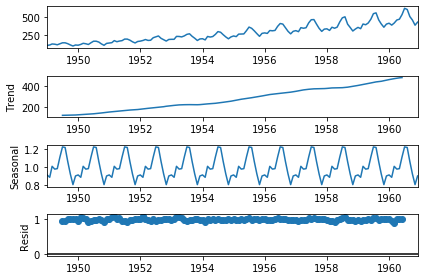

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

df = pd.read_csv('data/AirPassengers.csv', parse_dates=['Month']).set_index('Month')
decomposed = seasonal_decompose(df, model='multiplicative', period=12)
decomposed.plot()
plt.show()

But this hardly leaves me with a feeling of knowing . . . anything. And I'm also not sure how it solves me problem.

## Resources
- [Decomposing Time Series in R](https://anomaly.io/seasonal-trend-decomposition-in-r/index.html)
> This is a great explanation of multiplicative and additive time series decomposition
- [Forecasting Time Series Book FREE](https://otexts.com/fpp2/)
> A great resource on Time Series by the author of the fpp package in R.